[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/timpdotd/LabIAGI_1950722/tree/408d4077a2ed2906ba3a3145586fc761e9f4380e/Esercitazione_7)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1gr1otix8Ri2DXOcTdW7Zn-vXOe7ph-sr?usp=sharing)

# Field test del MultiLayer Perceptron

Questo è il testo dell'esercitazione che dovrete completare per questa settimana. Non sarà guidato passo passo, ma
dovrete usare quello che avete imparato negli altri jupyter notebooks per addestrare dei modelli e cross-validarli,
al massimo delle vostre capacità.
I tre esercizi da svolgere sono:

1. addestrare un MLP su [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Potete utilizzare il codice
 del precedente notebook, ma vi consiglio di riscriverlo in maniera più ordinata. In questo caso, fate prima
 un'analisi dei dati per capire con cosa avete a che fare.
2. addestrare un MLP su [YearPredictionMSD](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD): l'idea di
      questo esercizio è quella di utilizzare una rete neurale per migliorare le performance rispetto alla soluzione
      che avete già implementato con la logistic regression nell'[esercitazione 6](https://github.com/Sapienza-AI-Lab/esercitazione6-22-23). In questo caso l'aspetto che ci
      preme esplorare è l'efficacia del MLP nell'imparare una rappresentazione (i.e. delle features) migliore per la
      classifcazione, o la regressione. Questo esercizion non è banale e sono interessato a vedere come sfrutterete
      le reti neurali per migliorare le prestazioni. Se non avete fatto l'EDA durante la scorsa esercitazione, questo è il momento di farla.
3. addestrare un MLP su CIFAR-10: riprenderemo questo dataset anche con le reti convoluzionali, ma iniziamo a
      farci un'idea delle sue caratterisitche addestrando im modello migliore possibile utilizzando un MLP. La sfida
      in questo caso sarà la dimensionalità dell'input, e quindi delle connessioni del MLP.


In tutti i casi tenete conto di questi aspetti:
* Non siete costretti ad usare i notebook. Personalmente non li amo, ma sono adatti a presentare il codice per la
    didattica. Per lavorare con progetti di una certa complessità è spesso meglio passare ad un normale progetto
    python. Ovviamente se non avete una GPU nel vostro portatile/desktop, l'unica soluzione è colab.
* Utilizzate tensorboard o weight and biases per la visualizzazione e per fare il debug del vostro modello. Non provate le cose a caso.

# MLP su FashionMNIST

---



## Import Libraries

In [93]:
%matplotlib inline
%reload_ext tensorboard

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random

# This is when we use GPU instance to run colab.
# How to change Runtime in colab??
# Go to Runtime-> Change Runtime type -> Hardware Accelerator -> GPU

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Defining seed to make every experiment reproducible

In [94]:
SEED = 42

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Load Dataset

Train set

In [95]:
# Setting transformation to every image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

Validation set

In [96]:
validation_set = datasets.FashionMNIST(root='./data', train=False, download=False, transform=transform)
validation_loader = DataLoader(validation_set, batch_size=64, shuffle=False)
validation_set

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

Test set

In [97]:
test_set = datasets.FashionMNIST(root='./data', train=False, download=False, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
test_set

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

## Exploratory data analysis

From the bottom results we can say that:
* Every image has a dimension of 28x28 pixel
* Every class has 6000 samples

In [98]:
images = train_set.data
labels = train_set.targets

print("Dataset size:", len(train_set))
print("Image shape:", images[0].shape)
print("Labels:", labels.unique())
print("Class distribution:")
for class_label in labels.unique():
    print(f"Class {class_label.item()}: {torch.sum(labels == class_label).item()} samples")

Dataset size: 60000
Image shape: torch.Size([28, 28])
Labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Class distribution:
Class 0: 6000 samples
Class 1: 6000 samples
Class 2: 6000 samples
Class 3: 6000 samples
Class 4: 6000 samples
Class 5: 6000 samples
Class 6: 6000 samples
Class 7: 6000 samples
Class 8: 6000 samples
Class 9: 6000 samples


In [99]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


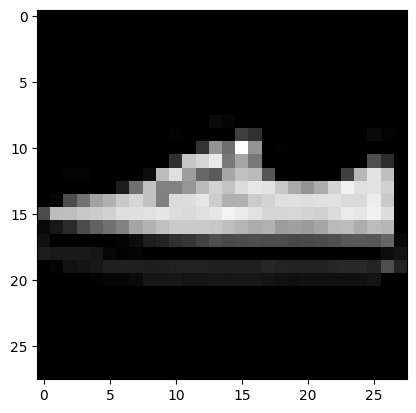

In [100]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

Every class is a type of clothes, as stated below:

0.	T-shirt/top
1.	Trouser
2.	Pullover
3.	Dress
4.	Coat
5.	Sandal
6.	Shirt
7.	Sneaker
8.	Bag
9.	Ankle boot



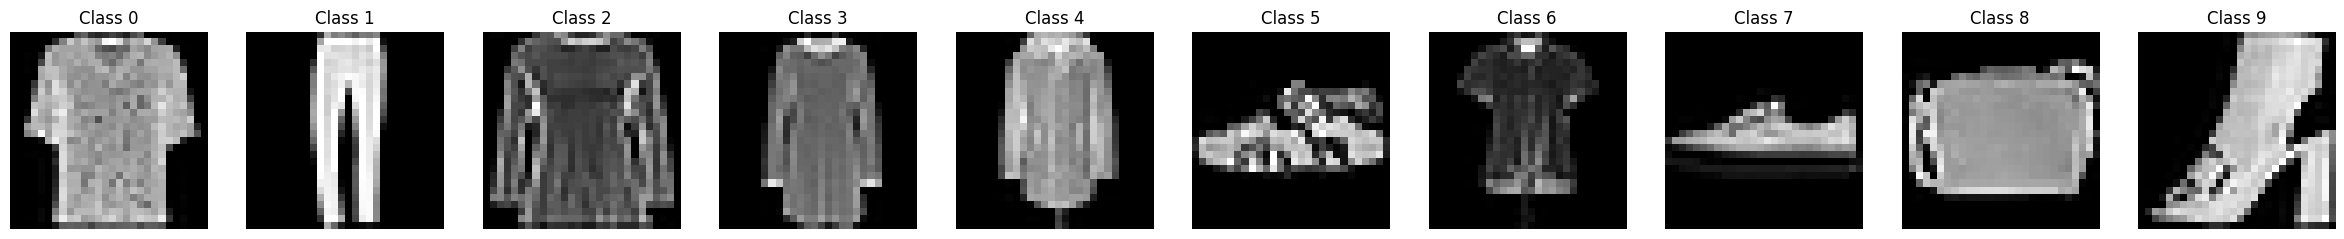

In [101]:
# Print a sample for every class
num_classes = len(labels.unique())
plt.figure(figsize=(30, 30))
for i in range(num_classes):
    plt.subplot(1, 10, i+1)
    class_images = images[labels == i]
    plt.imshow(class_images[0].numpy().squeeze(), cmap='gray')  # Convert to NumPy array and squeeze
    plt.title(f"Class {i}")
    plt.axis('off')
plt.show()

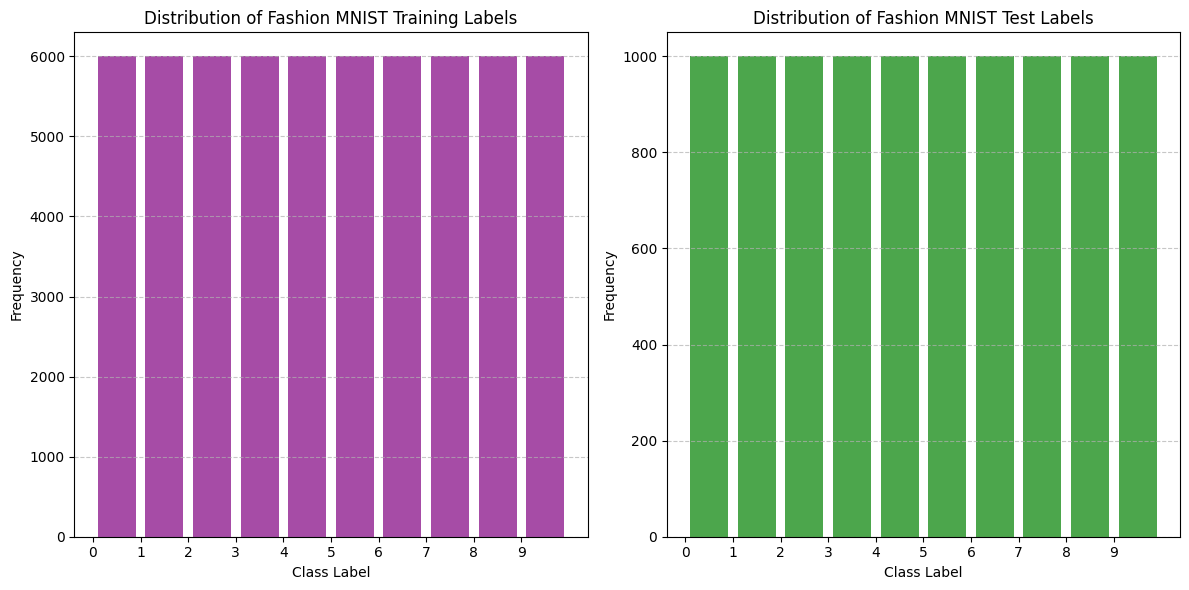

In [102]:
train_labels = train_set.targets
test_labels = test_set.targets

# Plot histograms
plt.figure(figsize=(12, 6))

# Plot histogram for training set
plt.subplot(1, 2, 1)
plt.hist(train_labels, bins=range(11), rwidth=0.8, alpha=0.7, color='purple')
plt.title('Distribution of Fashion MNIST Training Labels')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot histogram for test set
plt.subplot(1, 2, 2)
plt.hist(test_labels, bins=range(11), rwidth=0.8, alpha=0.7, color='green')
plt.title('Distribution of Fashion MNIST Test Labels')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

**Osservazione**: i dati sono distribuiti molto bene in tutte le classi del dataset.

## Model

The MLP classifier is caratterized as described [HERE](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com). It has:
* Input: 784 (total pixels in every image)
* Hidden: 3 layers with 256, 128 and 100 units
* Output: 10 (we have 10 types of clothes)

In [103]:
"""
The MLP classifier
784 input units (images are 28 x 28)
3 hidden (256, 128, 100)
10 output (we have 10 classes)

Activation function: ReLU (Rectified Linear Unit). It's responsible of introducing
a non-linearity in the model. The main function is to determine the output of a node
or a set of nodes based on the input

Dropout 30%: randomly turn off 30% of the neurons of the input, giving us a
mechanism of regularization that prevents overfitting

Forward: generate a tensor of logaritmic probabilites associated to every class
for every record in the batch. These probabilities are obtained using log-softmax
in the final outpu
"""
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer_1 = nn.Linear(784, 256)
        self.activation_l1 = nn.ReLU()
        self.layer_2 = nn.Linear(256, 128)
        self.activation_l2 = nn.ReLU()
        self.layer_3 = nn.Linear(128, 100)
        self.activation_l3 = nn.ReLU()
        self.layer_4 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input images
        x = self.layer_1(x)
        x = self.activation_l1(x)
        x = self.dropout(x)
        x = self.layer_2(x)
        x = self.activation_l2(x)
        x = self.dropout(x)
        x = self.layer_3(x)
        x = self.activation_l3(x)
        x = self.dropout(x)
        x = self.layer_4(x)
        return F.log_softmax(x, dim=1)

model = Classifier()

In [104]:
"""
NLLLoss is commonly used in Classification tasks
SGD minimize the loss function regulating the model's parameters
"""
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()
print(model)

Classifier(
  (layer_1): Linear(in_features=784, out_features=256, bias=True)
  (activation_l1): ReLU()
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (activation_l2): ReLU()
  (layer_3): Linear(in_features=128, out_features=100, bias=True)
  (activation_l3): ReLU()
  (layer_4): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [105]:
"""
This function trains the neural network on each batch by resetting gradients,
performing forward pass, calculating loss, backpropagating gradients,
optimizing parameters using SGD, and printing training progress.
"""
def train(epoch, log_interval=200):
    model.train()
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.view(images.size(0), -1)  # Flatten the images
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(images),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item())
            )

In [106]:
"""
This function validates the neural network by evaluating its performance on the
validation set. It calculates the loss and accuracy, appends them to the
respective vectors, and prints the validation results.
"""
def validate(loss_vector, accuracy_vector):
  model.eval()
  correct_count = 0
  incorrect_count = 0
  total_count = 0

  for images, labels in validation_loader:
    with torch.no_grad():
      images = images.view(images.shape[0], -1)
      outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    correct_count += (predicted == labels).sum().item()
    incorrect_count += (predicted != labels).sum().item()
    total_count += labels.size(0)

  accuracy = 100*(correct_count/total_count)
  loss = incorrect_count/total_count

  loss_vector.append(loss)
  accuracy_vector.append(accuracy)

  print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss,
        correct_count,
        total_count,
        accuracy)
  )

In [107]:
epochs = 10
lossv, accv = [], []
for epoch in range(1, epochs+1):
  train(epoch)
  validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294996
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.078985
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.575108
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.258824
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.031285

Validation set: Average loss: 0.3205, Accuracy: 6795/10000 (67.95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.933520
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.964363
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.973572
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.847063
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.683194

Validation set: Average loss: 0.2488, Accuracy: 7512/10000 (75.12%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.783249
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.737373
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.658159
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.723663
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.489539

Validation set: Average loss: 0.2169, Accuracy: 7831/10000 (78.31%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.572459
Train Epoc

Plot validation loss and accuracy side by side

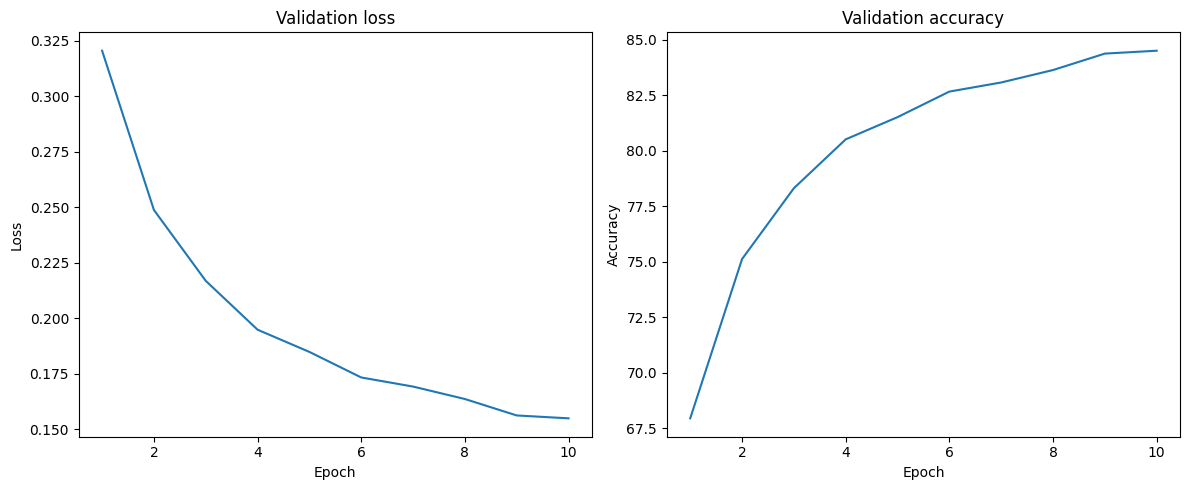

In [108]:
# Create subplots within a single figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot validation loss
axes[0].plot(np.arange(1, epochs + 1), lossv)
axes[0].set_title('Validation loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Plot validation accuracy
axes[1].plot(np.arange(1, epochs + 1), accv)
axes[1].set_title('Validation accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

This code visualizes the model's predictions by displaying a set of images from the test set along with their predicted and true labels. It uses matplotlib to plot the images and labels, highlighting correct predictions in green and incorrect predictions in red.

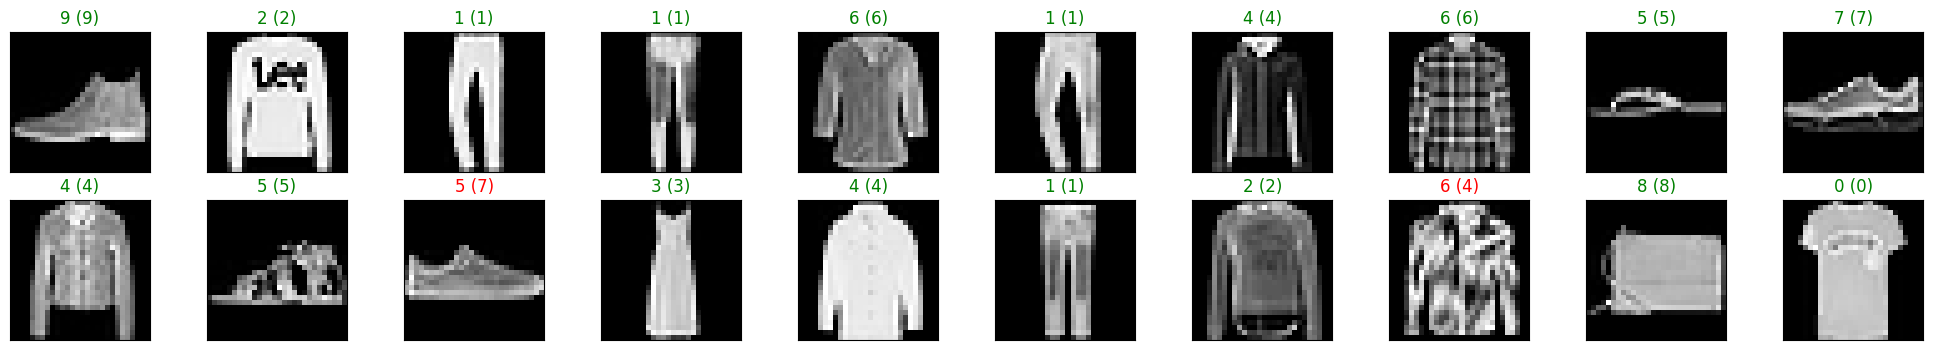

In [109]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

#Get sample outputs
output = model(images)

_, preds = torch.max(output,1)

#Prep images for display
images = images.numpy()

#Plot the images in the batch along with the predicted and true labels
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))


plt.show()